In [1]:
# Suppress debugging information about GPU
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import os.path
import sys
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
from matplotlib import pyplot as plt
from numpy import mean, std
from keras.initializers import RandomUniform, GlorotUniform, Zeros
from keras.layers import Dense, InputLayer
from keras.losses import MeanSquaredError
from keras.metrics import BinaryAccuracy
from keras.models import Sequential
from keras.optimizers import *
from keras.regularizers import L2, L1
from keras.callbacks import Callback
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from keras_tuner import GridSearch
from pathlib import Path
from cup_helpers import *

# set random seed for reproducible experiments
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

### Utilities

In [2]:
# read CSV dataset
def read_ds_df(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ["id", "INPUT_0", "INPUT_1", "INPUT_2", "INPUT_3", "INPUT_4", "INPUT_5", "INPUT_6", "INPUT_7", "INPUT_8", "INPUT_9", "TARGET_x", "TARGET_y", "TARGET_z"]
  data = pd.read_csv(path, dtype=object, delimiter=",", header=None, skiprows=1, names=names)
  y = data.drop(["id","INPUT_0", "INPUT_1", "INPUT_2", "INPUT_3", "INPUT_4", "INPUT_5", "INPUT_6", "INPUT_7", "INPUT_8", "INPUT_9"], axis=1)
  X = data.drop(["id","TARGET_x", "TARGET_y", "TARGET_z"], axis=1).astype(float)
  y = y.astype(float)

  return (X , y)

# read CSV blind test-set
def read_ts_df(path):
  names = ['id','input0', 'input1', 'input2', 'input3', 'input4', 'input5', 'input6', 'input7', 'input8', 'input9']
  df = pd.read_csv(path, names=names, dtype=object, header=None, skipinitialspace=True, skiprows=7)
  return df.drop(['id'],axis=1).astype(float)

In [3]:
# preprocessing: load and split dataset
(X, y) = read_ds_df("data/ML-CUP23-TR.csv")

#split 80% dev and 20% train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)

# blind test set
blind_test = read_ts_df("data/ML-CUP23-TS.csv")

In [4]:
# Mean Euclidean Error metric for sklearn GridSearchCV
def mee(hx, y):

  if y.ndim > 1:
    l2_norms = np.linalg.norm(np.subtract(hx, y), axis=1)
    return mean(l2_norms, axis=0)
  else:
    l2_norms = []
    for p in range(len(y)):
      l2_norms.append(np.linalg.norm(np.subtract(hx[p], y[p])))
    return mean(l2_norms)
      
custom_scores = {
  "mee": make_scorer(mee, greater_is_better=False),
}

In [5]:
#custom metric to introduce mee on Keras
@tf.autograph.experimental.do_not_convert
def mee_NN(hx, y):
  error = y - hx
  l2_norm = tf.norm(error, ord=2, axis=1)
  return tf.keras.backend.mean(l2_norm, axis=0)

In [6]:
# get_NN: Function that builds up a NN
def get_NN(X_len, initializer="random", seed=42, hidden_layers=[{"neurons":4,"activation":"tanh"}],
          lr=0.01, alpha=0.5, lambda_reg=None, penalty=None, nesterov=False):

  # weight initialization
  init, bias = (GlorotUniform(seed=seed), Zeros())  if initializer=="glorot" \
          else (RandomUniform(seed=seed), RandomUniform(seed=seed))

  # regularization
  regularizer = L1(l1=lambda_reg) if penalty == "L1" \
          else  L2(l2=lambda_reg) if penalty == "L2" \
          else  None

  # 1 hidden layer
  NN_model = Sequential()
  NN_model.add(InputLayer(input_shape=(X_len,)))

  for layer in hidden_layers:
    NN_model.add(Dense(layer["neurons"],  activation=layer["activation"], 
                kernel_initializer=init, bias_initializer=bias, kernel_regularizer=regularizer)
    )

  # output layer
  NN_model.add(Dense(units=3, activation = "linear", kernel_initializer=init, 
              bias_initializer=bias, kernel_regularizer=regularizer)
  )

  NN_model.compile(optimizer=SGD(learning_rate=lr, momentum=alpha, nesterov=nesterov), loss=mee_NN )
  
  return NN_model

In [7]:
# utilities to get the mean of K histories

def add_padding(ls, n):
  ls.extend([ls[-1]] * n)
  return ls

def longest(ls):
  return len(max(ls, key=(lambda history : len(history['loss'])))['loss'])

def mean_epochs(l):
  return int(mean([ len(item['loss']) for item in l ]))

def mean_history(_histories):
  m = mean_epochs(_histories)+1
  # m = longest(_histories)
  for history in _histories:
    l = len(history['loss'])
    for field in _histories[0]:
      if l>= m:
        history[field] = history[field][:m]
      else:
        history[field] = add_padding(history[field], (m-l))
  return \
    { field : 
        [ 
          (sum(x)/len(_histories)) for x in zip(
            *[ history[field] for history in _histories ]
          )
        ] for field in _histories[0]
    }

In [8]:
# static fold counter
def count():
  count.count += 1
  return count.count

def reset_counter():
  count.count =-1

def get_count():
  return count.count

In [9]:
# static history register
def histories():
  histories.histories = []

def register(h):
  histories.histories.append(h)

def get_histories():
  return histories.histories

def clear_histories():
  histories()

In [10]:
# plot utility
def do_NN_plot(history):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'],  linestyle="--", color="orange")
  plt.title(f'model MEE')
  plt.ylabel('MEE')
  plt.xlabel('epoch')
  plt.legend(['training', 'test'], loc='upper right')
  plt.show()

In [11]:
# KerasRegressor Wrapper for kfold
class KRWrapper(KerasRegressor):

  def __init__(self, val_data, k, *args, **kwargs):
    super(KRWrapper, self).__init__(*args, **kwargs)
    self.val_data = val_data
    self.k = k
    
  def fit(self, X, y, **kwargs):
    h = super().fit(X, y, validation_data=self.val_data[count()], **kwargs)
    register(h.history_)
    # do_NN_plot(h.history_)  # plot single fold curve
    if self.kfold_finished(): # plot mean of k folds curves
      do_NN_plot(mean_history(get_histories()))
    
  def kfold_finished(self):
    return self.k == get_count()+1

#### Model Selection

In [14]:
# Define grids for gridsearchcv
kerasRegressorParams = {
  "model" : get_NN,
  "X_len" : len(X_train.columns),
  "loss" : mee_NN,
  "optimizer" : "SGD", # fixed into get_NN
  #"batch_size" : 4,
  "epochs" : 2000,
  "shuffle" : True,
  "verbose" : False
}

NN = KerasRegressor(**kerasRegressorParams)

GRID_DICT = {
  "batch_size" : [64, 500],
  "model__lr" : [0.01, 0.2], # [0.01, 0.2, 0.22, 0.25, 0.3, 0.4, 0.5]
  "model__alpha" : [0.8, 0.5], # [0.5, 0.55, 0.6, 0.62, 0.7, 0.79, 0.8, 0.81, 0.9]
  "model__initializer" : ["glorot"], # ["random", "glorot"]
  "model__nesterov" : [True], # [True, False]
  "model__penalty": ["L2"], # [None, "L1", "L2"],
  "model__lambda_reg": [0.01, 0.005], # [0.01, 0.005]
  "model__seed" : [15],
  "model__hidden_layers" : [ 
    [
      { 
        "neurons": (32,), 
        "activation":"tanh"
      }, 
      {
        "neurons": (16,),
        "activation":"tanh"
      },
      {
        "neurons": (8,),
        "activation":"tanh"
      }
    ],
    [
      { 
        "neurons": (32,),
        "activation":"relu"
      }, 
      {
        "neurons": (16,),
        "activation":"relu"
      },
      {
        "neurons": (8,),
        "activation":"relu"
      }
    ]
  ]
}

grid = GridSearchCV(NN,
                    param_grid=GRID_DICT,
                    scoring=custom_scores,
                    refit="mee",
                    cv=CV,
                    return_train_score=True,
                    n_jobs=-1,
                    
        )

In [15]:
# exec gridsearch and fit model
grid.fit(X_train, y_train)
print("Best parameters: " + str(grid.best_params_) + " score: " + str(grid.best_score_))

Best parameters: {'batch_size': 64, 'model__alpha': 0.8, 'model__hidden_layers': [{'neurons': 16, 'activation': 'tanh'}, {'neurons': 8, 'activation': 'tanh'}], 'model__initializer': 'glorot', 'model__lambda_reg': 0.001, 'model__lr': 0.001, 'model__nesterov': True, 'model__penalty': 'L2', 'model__seed': 15} score: -2.253827640501193


In [16]:
# print top hyperparameters and results
columns = ['param_model__nesterov', 'param_model__alpha', 'param_model__lr', 'mean_test_mee', 'std_test_mee', 'mean_fit_time']
top_models = pd.DataFrame(grid.cv_results_).sort_values(by=['mean_test_mee'])[:3]
top_models[columns]

,param_model__nesterov,param_model__alpha,param_model__lr,mean_test_mee,std_test_mee,mean_fit_time
0,True,0.8,0.001,-2.253828,0.263772,71.485181


In [17]:
# second kfold: validation curves, early stopping and mean error of top models

# validation folds
val_split = [ test for (train, test) in CV.split(X_train, y_train) ]

val_data = [ 
  (
    [X_train.iloc[i].tolist() for i in indexes], 
    [y_train.iloc[i].tolist() for i in indexes]
  ) for indexes in val_split 
]

NN_2 = KRWrapper(
  val_data,
  5,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
      monitor="val_loss", min_delta=0.0001, patience=20, restore_best_weights=True
    )
  ],
  **kerasRegressorParams
)

grid_dict = { "scoring": custom_scores,
              "refit" : False,
              "cv" : CV,
              "return_train_score" : True,
              "n_jobs" : 1,
}

{'batch_size': 64, 'model__alpha': 0.8, 'model__hidden_layers': [{'neurons': 16, 'activation': 'tanh'}, {'neurons': 8, 'activation': 'tanh'}], 'model__initializer': 'glorot', 'model__lambda_reg': 0.001, 'model__lr': 0.001, 'model__nesterov': True, 'model__penalty': 'L2', 'model__seed': 15}
Seed: 15


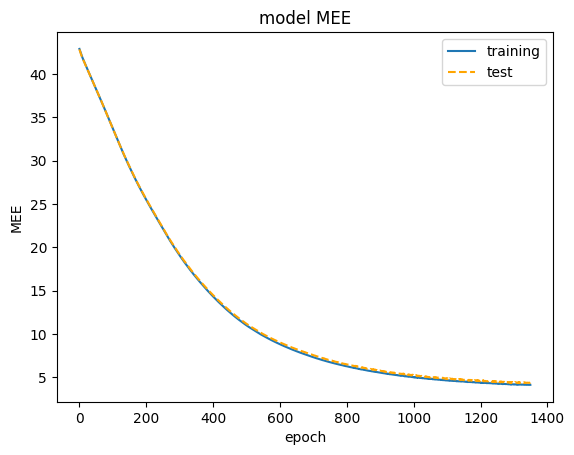

Seed: 16


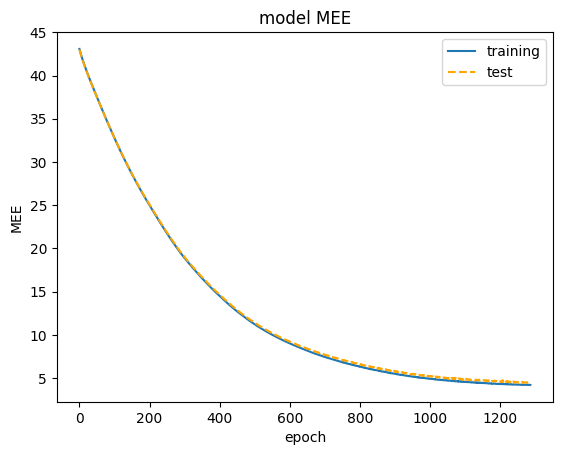

Seed: 17


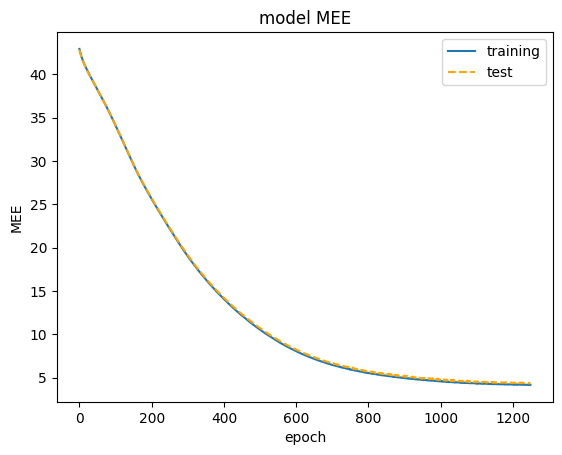

Seed: 18


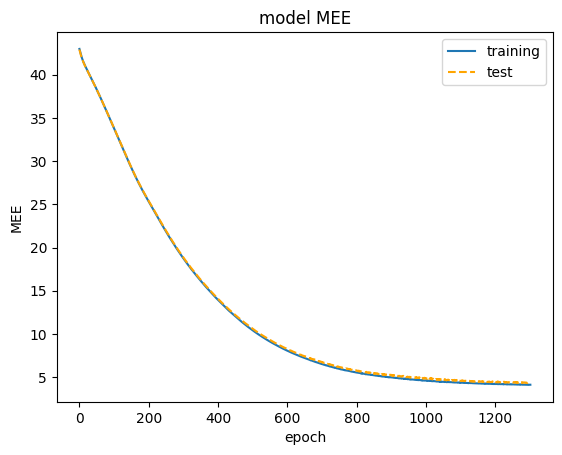

Seed: 19


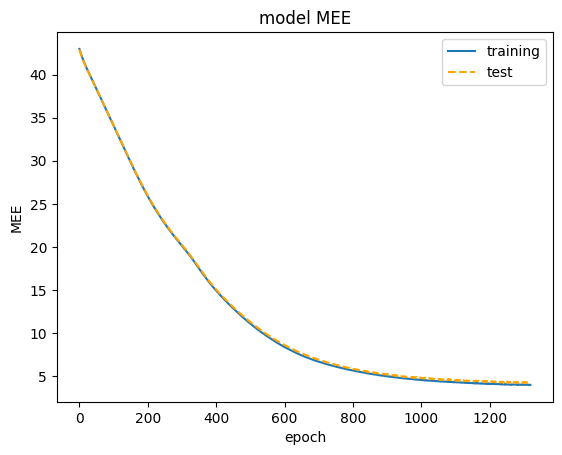

Tr mean mee over 5 inits -2.595035 +/- 0.074758 (std)

Vl mean mee over 5 inits -2.848080 +/- 0.068526 (std)



In [18]:
# exec kfold and select the model

seed = GRID_DICT['model__seed'][0]

n_epochs = []

for params in top_models['params']:
  print(params)

  tr_err, tr_acc, ts_err, ts_acc = [], [], [], []
  for i in range(seed, seed+5):
    print("Seed: " + str(i))

    # reset fold counter and histories
    reset_counter()   
    clear_histories() 

    # set params and seed
    grid_dict['param_grid'] = { field : [value] for (field, value) in params.items() }
    grid_dict['param_grid']['model__seed'] = [i]
    grid_2 = GridSearchCV(NN_2, **grid_dict)
    grid_2.fit(X_train, y_train)

    # save mse and accuracy 
    tr_err.append( grid_2.cv_results_['mean_train_mee'] ) 
    ts_err.append( grid_2.cv_results_['mean_test_mee'] ) 

    # memorize number of epochs (mean over the five folds)
    n_epochs.append(mean([ len(get_histories()[i]['loss']) for i in range(5) ]))

  print("Tr mean mee over 5 inits {:.6f} +/- {:.6f} (std)\n" \
        .format( mean(tr_err), std(tr_err) )
  )

  print("Vl mean mee over 5 inits {:.6f} +/- {:.6f} (std)\n" \
        .format( mean(ts_err), std(ts_err) )
  ) 

#### Model Assessment

In [ ]:
# retrain on the whole ds and plot test 
NN_params = { field[7:] : value[0] for (field, value) in GRID_DICT.items() }
NN = get_NN(len(X_train.columns), **NN_params)
batch_size = kerasRegressorParams['batch_size']

h = NN.fit(X_train, y_train, batch_size=batch_size, epochs=int(mean(n_epochs)),\
    validation_data=(X_test, y_test), shuffle=True, verbose=0)

score = NN.evaluate(X_test, y_test)
print("Model Assessment\nMSE: {:.6f}".format(score) )

do_NN_plot(h.history)